### itk_registration_tutorial.ipynb
##### Uses ITK to register two scans from the same sample together. Shows importance of iterative approach -- start with simple registrations and gradually getting more complex
###### David Perlmutter
###### 11/5/21


In [1]:
%matplotlib widget
import os
import numpy as np
import h5py
from tqdm import tqdm
from skimage import io, transform, util
import SimpleITK as sitk
from matplotlib import pyplot as plt
from ipywidgets import interact, fixed, IntSlider

In [2]:
##### File paths to data on NERSC
base_path = '/global/cscratch1/sd/dperl/battery_data/'
registered_path = base_path + "new_roi/"
unregistered_path = base_path + "intermediate/"
##### Scans were collected every 10 min for 240 min. Will register the last two together
fixed_stack = 240 
moving_stack = 230 # this volume will be interpolated to coordinates of fixed stack
vol_fx = h5py.File(registered_path+f"IM_298-1_{fixed_stack:03d}.h5",'r')['data']
vol_mv = h5py.File(unregistered_path+f"IM_298-1_{moving_stack:03d}.h5",mode='r')['data']
print(f"Fixed vol shape: {vol_fx.shape}, {vol_fx.dtype}")
print(f"Moving vol shape: {vol_mv.shape}, {vol_mv.dtype}")

Fixed vol shape: (698, 3896, 1707), uint8
Moving vol shape: (800, 3624, 2584), uint8


##### Registration is much easier (and faster) working with a single interesting feature of a smaller subvolume, rather than the entire 1k^3 volume. We'll plot volumes side-by-side to find a corresponding feature

interactive(children=(IntSlider(value=277, description='z_fx', max=697), IntSlider(value=344, description='z_m…

<function __main__.slicer(z_fx, z_mv)>

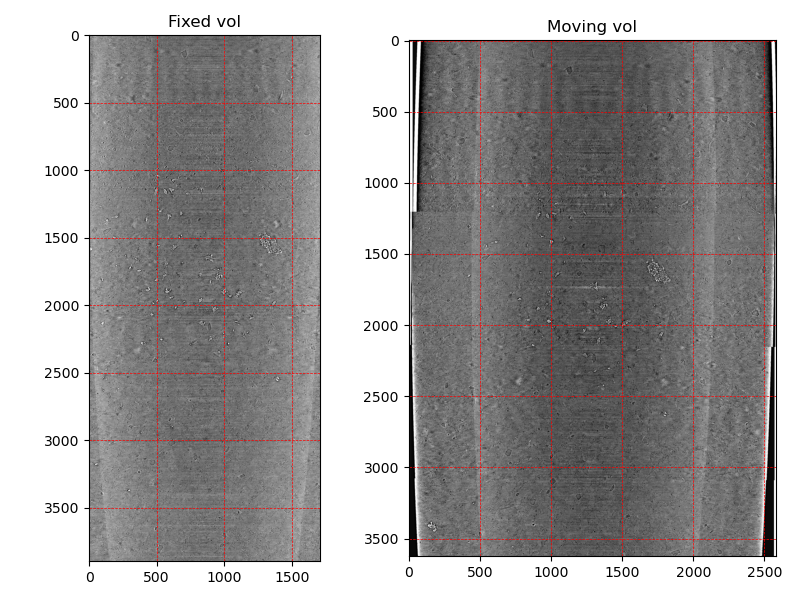

In [4]:
##### Plot 
def slicer(z_fx,z_mv):
    img0.set_data(vol_fx[z_fx,:,:])
    img1.set_data(vol_mv[z_mv,:,:])

if plt.fignum_exists(1): plt.close(1)
fig, axs = plt.subplots(1,2,num=1,figsize=(8,6))
img0 = axs[0].imshow(vol_fx[vol_fx.shape[0]//2,:,:],cmap='gray')
img1 = axs[1].imshow(vol_mv[vol_mv.shape[0]//2,:,:],cmap='gray')
axs[0].grid(color='r', linestyle='--', linewidth=0.5,which='both')
axs[1].grid(color='r', linestyle='--', linewidth=0.5,which='both')
axs[0].set_title("Fixed vol")
axs[1].set_title("Moving vol")
plt.tight_layout()
interact(slicer,z_fx=IntSlider(min=0,max=vol_fx.shape[0]-1,value=277),
                z_mv=IntSlider(min=0,max=vol_mv.shape[0]-1,value=344))

In [5]:
loc_fx = np.asarray([277,1550,1350]) # center of fixed subvol
loc_mv = np.asarray([344,1650,1750]) # center of moving subvol
subvol_shape = [20, 150, 150] # from center to edge -- subvol will be twice this size in all dimensions

In [6]:
zind_fx = slice(loc_fx[0]-subvol_shape[0],loc_fx[0]+subvol_shape[0]+1)
xind_fx = slice(loc_fx[1]-subvol_shape[1],loc_fx[1]+subvol_shape[1]+1)
yind_fx = slice(loc_fx[2]-subvol_shape[2],loc_fx[2]+subvol_shape[2]+1)
zind_mv = slice(loc_mv[0]-subvol_shape[0],loc_mv[0]+subvol_shape[0]+1)
xind_mv = slice(loc_mv[1]-subvol_shape[1],loc_mv[1]+subvol_shape[1]+1)
yind_mv = slice(loc_mv[2]-subvol_shape[2],loc_mv[2]+subvol_shape[2]+1)
subvol_fx = util.img_as_float(vol_fx[zind_fx,xind_fx,yind_fx])
subvol_mv = util.img_as_float(vol_mv[zind_mv,xind_mv,yind_mv])
print(f"Sub-volume shape: {subvol_fx.shape}")

Sub-volume shape: (41, 301, 301)


In [7]:
##### Plotting helper function to view registration
def plot_registered_subvol(subvol_fx,subvol_mv,fignum=1):
    N = np.min([len(subvol_fx),len(subvol_mv)])
    subvol_err = subvol_fx - subvol_mv
    def slicer(z):
        img0.set_data(subvol_fx[z,:,:])
        img1.set_data(subvol_mv[z,:,:])
        img2.set_data(subvol_err[z,:,:])

    if plt.fignum_exists(fignum): plt.close(fignum)
    fig, axs = plt.subplots(1,3,num=fignum,sharex=True,sharey=True)
    img0 = axs[0].imshow(subvol_fx[N//2,:,:],cmap='gray',vmin=0,vmax=1)
    img1 = axs[1].imshow(subvol_mv[N//2,:,:],cmap='gray',vmin=0,vmax=1)
    img2 = axs[2].imshow(subvol_err[N//2,:,:],vmin=-1,vmax=1)
    axs[0].set_title("Fixed subvol")
    axs[1].set_title("Moving subvol")
    axs[2].set_title("Error")
    plt.tight_layout()

    interact(slicer,z=IntSlider(min=0,max=N-1,value=N//2))

interactive(children=(IntSlider(value=20, description='z', max=40), Output()), _dom_classes=('widget-interact'…

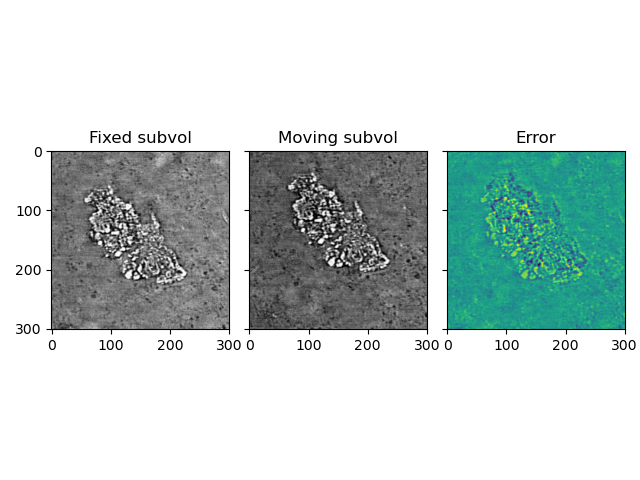

In [8]:
plot_registered_subvol(subvol_fx,subvol_mv,fignum=0)

##### ITK Transform #1: Exhaustive grid search, translation only 

In [9]:
# this code adapted from itk tutorial: https://simpleitk.readthedocs.io/en/master/link_ImageRegistrationMethod3_docs.html
def command_iteration(method):
    if (method.GetOptimizerIteration() == 0):
        scales = method.GetOptimizerScales()
        scales = [f", {s:.1f}" for s in scales]
        print(f"Estimated Scales:{scales}")
    if (method.GetOptimizerIteration() % 100 == 0):
        pos = method.GetOptimizerPosition()
        pos = [f", {p:.5f}" for p in pos]
        print(f"{method.GetOptimizerIteration():d} = {method.GetMetricValue():.3e} : {pos}")

    
def sitkRegistration_exhaustive(arr_shape,init,steps,scale,down=4,smooth=1):
    R = sitk.ImageRegistrationMethod()

    R.SetMetricAsCorrelation()

    R.SetOptimizerAsExhaustive( numberOfSteps=steps, stepLength=1)
    R.SetOptimizerScales(scale)

    tx = sitk.TranslationTransform(fixed.GetDimension())

    R.SetInitialTransform(tx)

    R.SetInterpolator(sitk.sitkLinear)

    R.SetShrinkFactorsPerLevel([down])
    R.SetSmoothingSigmasPerLevel([smooth])

    R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))
    return R, tx

In [10]:
# Helper function used by registration
def applyTx(fixed,moving,tx):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(tx)
    out = resampler.Execute(moving)
    return sitk.GetArrayFromImage(out)

In [11]:
%%time
##### Set grid search parameters and run registration
fixed = sitk.GetImageFromArray(subvol_fx)
moving = sitk.GetImageFromArray(subvol_mv)
tx_init = (0,0,0)
steps = [5, 5, 5] # number of grid sets 
scale = [10, 10, 1] # step size, in pixels 
down = 4 # downsampling (makes registration faster)
smooth = 1 # smoothing (can make registration more robust)
R,tx = sitkRegistration_exhaustive(fixed.GetSize(),tx_init,steps,scale,down,smooth)
tx1 = R.Execute(fixed, moving)

print("-------")
print(tx1)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")
subvol_reg1 = applyTx(fixed,moving,tx1)

Estimated Scales:[', 10.0', ', 10.0', ', 1.0']
0 = -5.632e-04 : [', -50.00000', ', -50.00000', ', -5.00000']
100 = -1.089e-03 : [', -40.00000', ', 40.00000', ', -5.00000']
200 = -1.385e-03 : [', -30.00000', ', 20.00000', ', -4.00000']
300 = -3.934e-03 : [', -20.00000', ', 0.00000', ', -3.00000']
400 = -2.649e-03 : [', -10.00000', ', -20.00000', ', -2.00000']
500 = -3.306e-03 : [', 0.00000', ', -40.00000', ', -1.00000']
600 = -3.079e-03 : [', 10.00000', ', 50.00000', ', -1.00000']
700 = -2.547e-03 : [', 20.00000', ', 30.00000', ', 0.00000']
800 = -3.479e-03 : [', 30.00000', ', 10.00000', ', 1.00000']
900 = -2.008e-03 : [', 40.00000', ', -10.00000', ', 2.00000']
1000 = -2.832e-03 : [', 50.00000', ', -30.00000', ', 3.00000']
1100 = -1.036e-03 : [', -50.00000', ', -40.00000', ', 4.00000']
1200 = -2.183e-03 : [', -40.00000', ', 50.00000', ', 4.00000']
1300 = -1.487e-03 : [', -30.00000', ', 30.00000', ', 5.00000']
-------
itk::simple::Transform
 TranslationTransform (0x55555817c580)
   RTTI 

interactive(children=(IntSlider(value=20, description='z', max=40), Output()), _dom_classes=('widget-interact'…

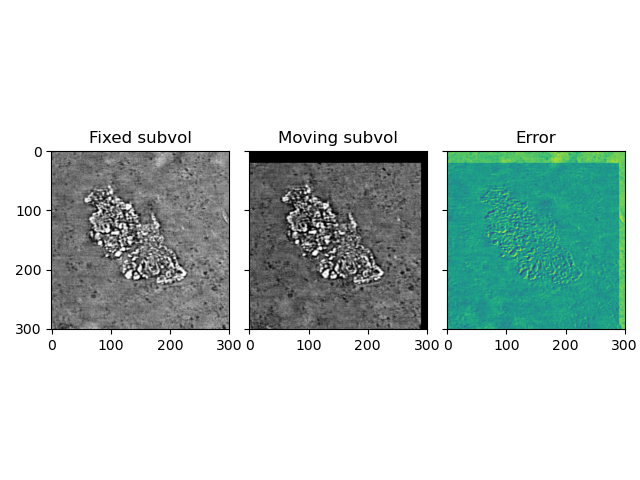

In [12]:
plot_registered_subvol(subvol_fx,subvol_reg1,fignum=1)

##### ITK Transform #2: Gradient descent search, translation only 

In [13]:
def sitkRegistration_trans(arr_shape,init):
    R = sitk.ImageRegistrationMethod()

    R.SetMetricAsCorrelation()
    # R.SetMetricAsMeanSquares()

    # R.SetOptimizerAsGradientDescent(learningRate=0.1,
    #                                 numberOfIterations=50,
    #                                 convergenceMinimumValue=1e-5)

    R.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                               minStep=1e-4,
                                               numberOfIterations=50,
                                               gradientMagnitudeTolerance=1e-8)    
    R.SetOptimizerScalesFromIndexShift()
    # R.SetOptimizerScalesFromJacobian()

    tx = sitk.TranslationTransform(3)
    tx.SetParameters(init)

    R.SetInitialTransform(tx)

    R.SetInterpolator(sitk.sitkLinear)

    R.SetShrinkFactorsPerLevel([2,1])
    R.SetSmoothingSigmasPerLevel([1,0])

    R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))
    return R, tx

In [14]:
%%time
fixed = sitk.GetImageFromArray(subvol_fx)
moving = sitk.GetImageFromArray(subvol_mv)
tx_init = tx1.GetParameters()
R,tx = sitkRegistration_trans(fixed.GetSize(),tx_init)
tx2 = R.Execute(fixed, moving)

print("-------")
print(tx2)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")
subvol_reg2 = applyTx(fixed,moving,tx2)

Estimated Scales:[', 1.0', ', 1.0', ', 1.0']
0 = -3.943e-01 : [', 8.58299', ', -21.40834', ', -0.09311']
Estimated Scales:[', 1.0', ', 1.0', ', 1.0']
0 = -6.488e-01 : [', 8.87684', ', -21.53689', ', 1.88688']
-------
itk::simple::Transform
 TranslationTransform (0x5555572e9410)
   RTTI typeinfo:   itk::TranslationTransform<double, 3u>
   Reference Count: 3
   Modified Time: 3962
   Debug: Off
   Object Name: 
   Observers: 
     none
   Offset: [8.64887, -21.265, -0.0647555]

Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Step too small after 23 iterations. Current step (6.10352e-05) is less than minimum step (0.0001).
 Iteration: 24
 Metric value: -0.648036230039368
CPU times: user 1min 16s, sys: 1.16 s, total: 1min 17s
Wall time: 5.5 s


interactive(children=(IntSlider(value=20, description='z', max=40), Output()), _dom_classes=('widget-interact'…

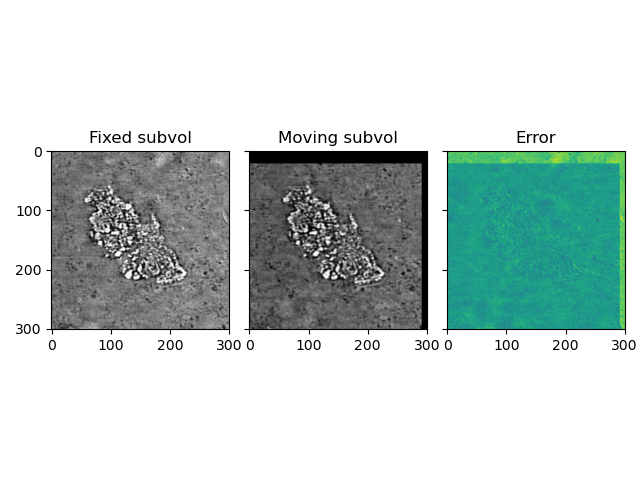

In [15]:
plot_registered_subvol(subvol_fx,subvol_reg2,fignum=2)

##### ITK Transform #3: Gradient descent search, translation and rigid rotation

In [16]:
def sitkRegistration_both(arr_shape,init):
    R = sitk.ImageRegistrationMethod()

    R.SetMetricAsCorrelation()

    # R.SetOptimizerAsGradientDescent(learningRate=0.1,
    #                                 numberOfIterations=50,
    #                                 convergenceMinimumValue=1e-5)

    R.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                               minStep=1e-4,
                                               numberOfIterations=50,
                                               gradientMagnitudeTolerance=1e-8)    
    
    R.SetOptimizerScalesFromIndexShift()
    # R.SetOptimizerScalesFromJacobian()

    # tx = sitk.TranslationTransform(3)
    # tx.SetParameters(init)

    # tx = sitk.Euler3DTransform()
    tx = sitk.VersorRigid3DTransform()
    tx.SetCenter(np.asarray(arr_shape)/2.0)
    tx.SetTranslation(init)
    # tx.SetParameters(init)

    R.SetInitialTransform(tx)

    R.SetInterpolator(sitk.sitkLinear)

    # R.SetMetricSamplingPercentage(0.1, sitk.sitkWallClock)
    # R.SetMetricSamplingStrategy(R.REGULAR)

    R.SetShrinkFactorsPerLevel([2,1]) 
    R.SetSmoothingSigmasPerLevel([1,0])

    R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))
    return R, tx

In [17]:
%%time
fixed = sitk.GetImageFromArray(subvol_fx)
moving = sitk.GetImageFromArray(subvol_mv)
tx_init = sitk.CompositeTransform([tx1, tx2]).GetParameters()
R,tx = sitkRegistration_both(fixed.GetSize(),tx_init)
tx3 = R.Execute(fixed, moving)

print("-------")
print(tx3)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")
subvol_reg3 = applyTx(fixed,moving,tx3)

Estimated Scales:[', 22730.3', ', 22730.3', ', 44700.1', ', 1.0', ', 1.0', ', 1.0']
0 = -7.355e-01 : [', -0.02672', ', -0.02011', ', 0.13115', ', 8.49261', ', -21.08860', ', -2.03217']
Estimated Scales:[', 23070.3', ', 23070.3', ', 45300.1', ', 1.0', ', 1.0', ', 1.0']
0 = -4.230e-03 : [', -0.02021', ', -0.00623', ', 0.08477', ', 3.94153', ', -15.97541', ', -1.32494']
-------
itk::simple::Transform
 VersorRigid3DTransform (0x55555651a350)
   RTTI typeinfo:   itk::VersorRigid3DTransform<double>
   Reference Count: 3
   Modified Time: 5506
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.999981 -0.00557781 -0.00243963 
     0.00557949 0.999984 0.000679953 
     0.0024358 -0.000693552 0.999997 
   Offset: [9.5673, -22.0324, -0.29533]
   Center: [150.5, 150.5, 20.5]
   Translation: [8.67504, -21.1812, -0.0331876]
   Inverse: 
     0.999981 0.00557949 0.0024358 
     -0.00557781 0.999984 -0.000693552 
     -0.00243963 0.000679953 0.999997 
   Singular: 0
   Versor: 

interactive(children=(IntSlider(value=20, description='z', max=40), Output()), _dom_classes=('widget-interact'…

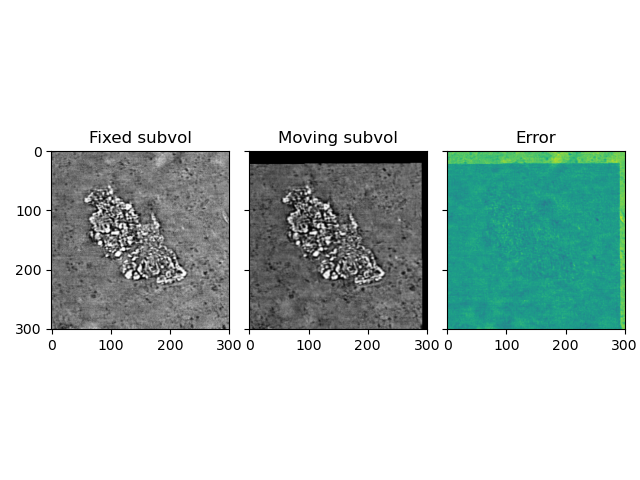

In [18]:
plot_registered_subvol(subvol_fx,subvol_reg3,fignum=3)

##### Create whole volume tranforms with two steps: 1) recenter rotation on full volume, 2) and add coarse subvolume translation

In [19]:
tx3_recentered = sitk.VersorRigid3DTransform() # create new itk tranform
tx3_recentered.SetParameters(tx3.GetParameters()) # copy rotation/translation parameters
tx3_recentered.SetFixedParameters(loc_fx.astype(float)[[2,1,0]]) # set rotation center at location of fixed sub volume (itk wants translation dimensions transposed in this way)

tx_init = sitk.TranslationTransform(3) # create coarse initial translation tranform
tx_init.SetParameters(tuple((loc_mv-loc_fx).astype(float)[[2,1,0]])) # set translation to align sub volumes (itk wants translation dimensions transposed in this way)

tx_final = sitk.CompositeTransform([tx_init, tx3_recentered])

In [20]:
fixed = sitk.GetImageFromArray(vol_fx)
moving = sitk.GetImageFromArray(vol_mv)
vol_reg = applyTx(fixed,moving,tx_final)

In [21]:
# Note: registered volume now has same dimensions as fixed volume
print(vol_fx.shape,vol_fx.dtype)
print(vol_mv.shape,vol_mv.dtype)
print(vol_reg.shape,vol_reg.dtype)

(698, 3896, 1707) uint8
(800, 3624, 2584) uint8
(698, 3896, 1707) uint8


interactive(children=(IntSlider(value=275, description='z', max=697), Output()), _dom_classes=('widget-interac…

<function __main__.slicer(z)>

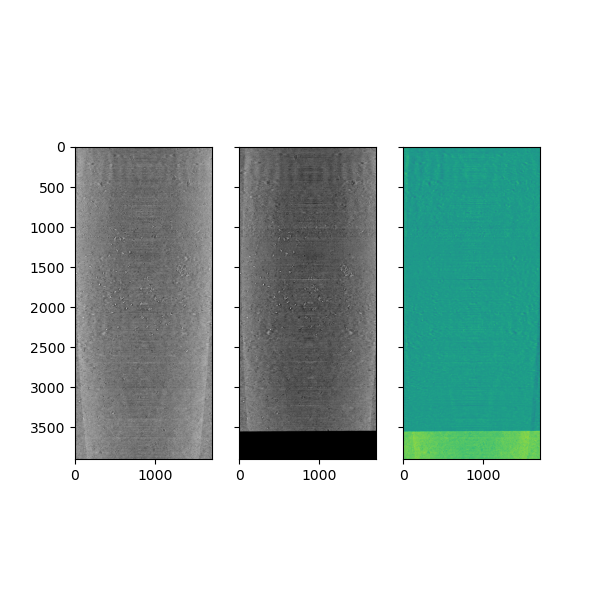

In [23]:
N = len(vol_fx)
def slicer(z):
    err_reg = vol_fx[z].astype(float) - vol_reg[z].astype(float)
    img0.set_data(vol_fx[z])
    img1.set_data(vol_reg[z])
    img2.set_data(err_reg)

tmp = np.empty((vol_fx.shape[1],vol_fx.shape[2]))
if plt.fignum_exists(4): plt.close(4)
fig, axs = plt.subplots(1,3,num=4,figsize=(6,6),sharex=True,sharey=True)
img0 = axs[0].imshow(tmp,cmap='gray',vmin=0,vmax=255)
img1 = axs[1].imshow(tmp,cmap='gray',vmin=0,vmax=255)
img2 = axs[2].imshow(tmp,vmin=-255,vmax=255)

interact(slicer,z=IntSlider(min=0,max=N-1,value=275))

In [ ]:
# save ITK transform
transform_name = f"./{moving_stack:03d}_to_{fixed_stack:03d}_transform.tfm"
sitk.WriteTransform(tx_final, transform_name)

In [ ]:
# save registered volume as zarr
hdf5_file = f"./{fixed_stack:03d}_registered.h5"
with h5py.File(hdf5_file,'a') as f:
    f.create_dataset('data', data=vol_reg)

In [ ]:
# save as big 3D tif
tif_name = f"./{fixed_stack:03d}_registered.tif"
io.imsave(tif_name+".tif",vol_reg_to_save)

In [ ]:
# save folder of tif slices
dir_name = f"./{fixed_stack:03d}_registered"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

for i,x in enumerate(tqdm(vol_reg)):
    io.imsave(dir_name + f"/img_{i:04d}.tif",x)